# Démonstration: Fit d'un spectre de rayonnement thermique

Comme dans le cas du spectre de luminescence du rubis, nous allons commencer par importer les modules qui seront nécessaires à notre analyse. Il s'agit des modules:

* `numpy` pour les mathématiques, la gestion des tableaux et l'ouverture de fichiers
* `matplotlib` pour le tracé graphique
* `scipy`, une bibliothèque pour le calcul scientifique, ici nous utiliserons la fonction `curve_fit` qui sert aux regression non linéaires



In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


# Pour tracer des figures de bonne qualité avec matplotlib (format vectoriel) directement dans le notebook :
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

On a ici procédé à 2 types d'import:

* le format `import module as alias` pour importer un module et toutes ses méthodes (fonctionnalités), que l'on pourra appeler en utilisant `alias.methode`.
* le format `from module import methode` qui permet de n'importer qu'une seule méthode (fonctionnalité), que l'on pourra appeler directement.

Notons que certains modules ont un format de "packages", c'est à dire qu'ils contiennent des sous-modules : c'est le cas par exemple dans l'instruction `from scipy.optimize import curve_fit` où seule la fonction `curve_fit` issue du sous-module `optimize` de `scipy` est chargée.

## Chargement du fichier de données

On commence par charger le fichier de données obtenu par la mesure de pyrométrie optique. Il s'agit d'un fichier texte qui contient deux colonnes : les longueurs d'onde en nm, et les intensités (en unité arbitaire).

In [39]:
# Read data from text file:
# les colonnes sont séparées par le caractère tab, codé par \t
data = np.loadtxt('data_planck.txt', delimiter='\t')

# La première colonne correspond aux longueurs d'ondes:
x_data = data[:,0]
# La seconde aux intensités:
y_data = data[:,1]

# affichons un aperçu des tableaux obtenus:
# l'instruction \n permet d'aller à la ligne dans un print
print('x: \n', x_data)
print('y: \n', y_data)

x: 
 [1073.5483087  1073.12515448 1072.70200025 ...  507.79110842  507.36795419
  506.94479997]
y: 
 [1.53097845e+10 2.09920867e+10 1.81776010e+10 ... 1.34773746e+10
 4.56444231e+09 7.96551438e+09]


## Tracé des données

Nous utilisons la bibliothèque `matplotlib` afin de visualiser les données. Nous ajoutons des étiquettes d'axes et une légende.

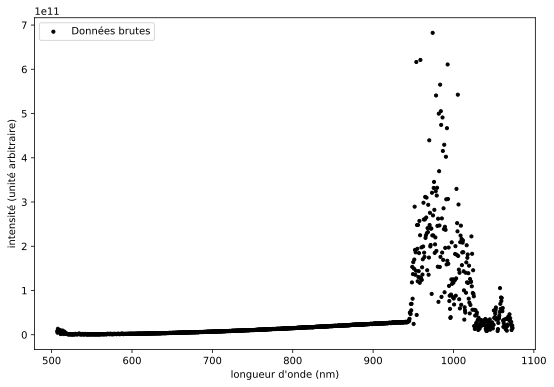

In [40]:
# on crée une figure et on précise ses dimensions (largeur,hauteur) :
plt.figure(figsize=(9,6))

# on trace les données sous la forme d'un nuage de points avec plt.scatter:
plt.scatter(x_data,   # abscisses
            y_data,   # ordonnées
            color='k', # k = black
            s=10,      # taille des points
            label='Données brutes') # étiquette pour la légende 

# titres des axes:
plt.xlabel("longueur d'onde (nm)")
plt.ylabel("intensité (unité arbitraire)")

plt.legend()
plt.show()

On remarque immédiatement des artefacts de mesure aux courtes longueurs d'onde et au dessus de 930 nm, principalement dus à l'utilisation de filtres sur le trajet optique. La région spectrale contenant les données utiles correspond à l'intervalle $[550, 930]$ nm. Nous allons exclure le reste de notre ajustement. 

## Selection de la partie utile des données

La condition `x_data > 550` renvoie un tableau de booléens de même longueur que `x_data`, contenant `True` ou `False` pour chacun des élements de `x_data`. 
Nous pouvons combiner plusieurs conditions de ce type, en utilisant les opérateurs `&` (et logique), `|` (ou logique) :
```
(x_data < 550) & (x_data > 930)
```

On peut utiliser ce tableau de booléen, résultat de la condition, pour indexer le tableau `x_data` :
```
x_data[(x_data < 550) & (x_data > 930)]
```
ainsi, seuls les élements de `x_data` correspondant à `True` sont renvoyés.
Nous pouvons donc utiliser cette condition pour sélectionner (filtrer) les données utiles de la façon suivante:

In [41]:
x = x_data[(x_data > 550) & (x_data < 930)]

# nous pouvons utiliser la même condition sur x pour filtrer y, car il y a correspondance biunivoque :
y = y_data[(x_data > 550) & (x_data < 930)] 

On trace ce nouveau jeu de données `(x,y)`, restreint à l'intervale de longueur d'onde $[550, 930]$ nm, dans une nouvelle figure :

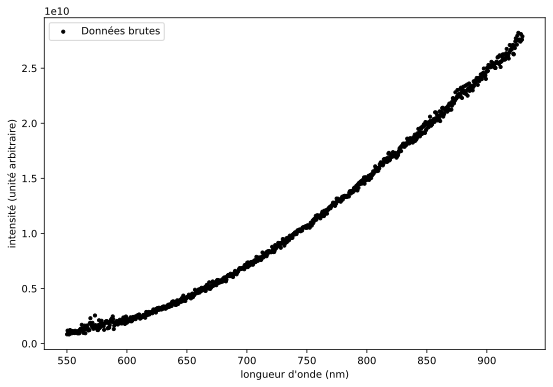

In [42]:
# on crée une nouvelle figure et on précise ses dimensions (largeur,hauteur) :
plt.figure(figsize=(9,6))

plt.scatter(x, 
            y, 
            color='k', # k = black
            s=10,      # taille des points
            label='Données brutes') 

plt.xlabel("longueur d'onde (nm)")
plt.ylabel("intensité (unité arbitraire)")

plt.legend()
plt.show()

## Ajustement par la loi de Planck

Le spectre est déjà normalisé par la fonction de transfert du montage expérimental, préalablement calibré. Il peut donc directement être analysé avec la loi de Planck. Dans notre programme, on définit la loi de Planck

$\LARGE I = \varepsilon \frac{2\pi h c^2}{\lambda^5} \frac{1}{e^{h c / \lambda k T} -1}$

sous la forme d'une fonction à trois variables : la longueur d'onde, l'émissivité $\varepsilon$ et la température $T$ que l'on cherche à déterminer. 
On se place dans l'approximation d'un corps gris, dont l'émissivité ne dépends pas de la longueur d'onde mais est une constante telle que $0<\varepsilon<1$. L'émissivité et la température seront ajustées lors du fit.

In [43]:
# définition des constantes nécessaires: 

h = 6.62607015e-34   # Planck's constant in J/s
c = 299792458        # Speed of light in m/s
k = 1.380649 * 1e-23 # Boltzmann constant in J/K


# définition de la fonction:

def planck(lamb, eps, temp):  # lamb doit être donné en mètres 
    f =  ( eps * ( 2*np.pi*h*c**2 / (lamb**5) ) * 
         1 / ( np.exp(h * c / (lamb * k * temp)) - 1 ) )
    return f

Nous utilisons la fonction `curve_fit` du module `scipy.optimize` pour réaliser le fit :

In [44]:
# on définit un jeu de paramètres initiaux pour le fit:
p_init = (0.5, 2000)   # epsilon, temp

# on peut ajouter des bornes limites aux paramètres:
p_bounds = ( (0, 1000), # valeurs minimales de (epsilon, temp)
             (1, 5000)) # valeurs maximales de (epsilon, temp)


# On appelle la fonction curve_fit, dont les arguments sont ici:
# curve_fit(modèle, x, y, p0 = paramètres initiaux, bounds=bornes)
# cette fonction renvoie deux sorties: le jeu des paramètres optimisés, et la matrice de covariance 
# /!\ x * 1e-9 car en nm !
p_fit, cov_fit = curve_fit(planck, x * 1e-9, y, p0 = p_init, bounds = p_bounds)

print('Résultats du fit :')
print('epsilon  = ', p_fit[0])
print('temp     = ', p_fit[1], 'K')

Résultats du fit :
epsilon  =  0.2550681718052653
temp     =  1820.2506130033032 K


On réalise une nouvelle figure qui contient les données brutes et le résultat du fit. On souhaite aussi visualiser les résidus du fit dans un second panneau.  Pour cela, nous utilisons la syntaxe `fig, axs = plt.subplots(2)` qui permet de générer une figure avec deux panneaux. La syntaxe est légèrement différente de cette utilisée ci-dessus avec `plt.figure()`. 

En général, la syntaxe appelant directement `plt`, comme `plt.figure`, `plt.plot`, est efficace pour réaliser rapidement une figure, mais moins flexible que `fig, ax = plt.subplots()` qui peut aussi être utilisée pour un seul panneau.

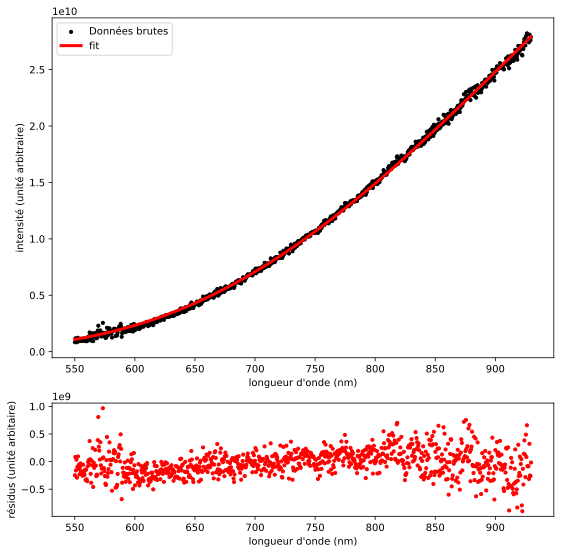

In [45]:
# Nous utilisons la syntaxe fig, axs = plt.subplots(2, ...)
# axs est un tableau de deux élements correspondant aux deux panneaux.
fig, axs = plt.subplots(2, figsize=(9, 9), height_ratios=(3,1))

# nous allons tracer nos courbe en appelant l'objet 'axs' dont les élements sont les panneaux:
# scatter pour les nuages de points:
axs[0].scatter(x, 
               y, 
               color='k', # k = black
               s=10,      # taille des points
               label='Données brutes') 

# plot pour les lignes:
axs[0].plot(x, 
            planck(1e-9 * x, p_fit[0], p_fit[1]),
            linewidth=3,   # épaisseur du trait
            color='r', # r = red
            label='fit')

# on calcule les résidus :
res = y - planck(1e-9 * x, p_fit[0], p_fit[1])

# on trace les résidus dans le second paneau comme un nuage de points:
axs[1].scatter(x, 
               res,
               color='r',
               s = 10)



# notons ici la syntaxe qui change légèrement ici : on utilise set_xlabel avec les objets axs, contrairement à plt ou l'on utilisait plt.xlabel. 
axs[0].set_xlabel("longueur d'onde (nm)")
axs[0].set_ylabel("intensité (unité arbitraire)")

axs[1].set_xlabel("longueur d'onde (nm)")
axs[1].set_ylabel("résidus (unité arbitaire)")

axs[0].legend()
plt.show()

Nous pouvons, pour l'exemple, calculer l'erreur de fit sur les paramètres à partir de la matrice de covariance. Celle-ci à été définie lors de l'appel à la fonction `curve_fit`, et stockée dans `cov_fit` (voir plus haut). 

In [46]:
print(cov_fit)

[[ 2.92643885e-06 -2.22189573e-03]
 [-2.22189573e-03  1.69905188e+00]]


Les éléments non-diagonaux de la matrice de covariance sont faibles, ce qui traduit l'indépendance des paramètres $\varepsilon$ et $T$, et est rassurant sur la qualité de notre fit.  Pour calculer les erreurs (écarts-type) sur les résultats du fit, on prends la racine des élements diagonaux :

In [47]:
err_fit = np.sqrt( np.diag(cov_fit) )

print('err_fit = ', err_fit)

# présentons nos résultats :
# Nous pouvons arrondir les valeurs avec la fonction round(x, nombre_de_décimales)
# si nombre_de_décimales est omis nous avons un arrondi à l'entier

print('\n') # saut de ligne
print('Résultats du fit :')
print('temp     = ', round(p_fit[1]),    '+/-', round(err_fit[1]), 'K')
print('epsilon  = ', round(p_fit[0], 3), '+/-', round(err_fit[0], 3))

err_fit =  [0.00171068 1.30347684]


Résultats du fit :
temp     =  1820 +/- 1 K
epsilon  =  0.255 +/- 0.002


Notons que ces erreurs sont seulement des erreurs mathématiques sur l'ajustement, __et sont beaucoup plus faibles que la véritable barre d'erreur expérimentale sur la température.__ 

## Pour aller plus loin

Dans cette section, nous allons approfondir notre analyse du spectre avec :

* Un fit dans l'approximation de Wien
* Une analyse par pyrométrie deux-couleurs glissante, qui permettra de quantifier l'erreur de mesure sur la température

Ces analyses sont basées sur la méthode présentée dans [Benedetti & Loubeyre, High Pressure Research __24__ 423-445 (2004)](https://www.tandfonline.com/doi/abs/10.1080/08957950412331331718).



### Fit dans l'approximation de Wien

Dans l'approximation de Wien on considère que la température est suffisemment faible pour que $\large e^{hc/\lambda kT} >> 1$. 
Dans ce cas on a :
$$
 \Large I \approx \varepsilon \frac{2\pi h c^2}{\lambda^5} \frac{1}{e^{h c / \lambda k T}} 
$$
En réarrangeant on peut définir la quantité :
$$
\Large Wien = \frac{k}{hc} \ln{\left(\frac{2 \pi h c^2}{I \lambda^5}\right)} = \frac{1}{T}  \frac{1}{\lambda} - \frac{k}{hc} \ln{\varepsilon}
$$

Ainsi la quantité $Wien (1/\lambda)$ est une droite de pente $1/T$. Nous allons calculer cette quantité et réaliser un fit linéaire pour obtenir une seconde détermination de $T$ et de $\varepsilon$.  Commençons par définir la fonction $Wien$, appliquons là à nos données et traçons la fonction $Wien (1/\lambda)$ :

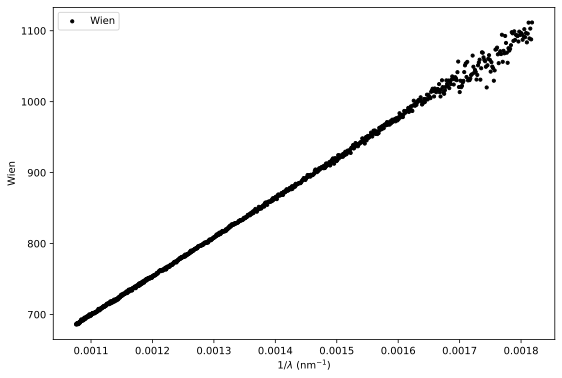

In [48]:
# définition d'une fonction Wien, où I correspond à l'intensité du spectre de Planck :
def wien(lamb, I):
    f = (k / (h*c)) * np.log(2 * np.pi * h * c**2 / (I * lamb**5) )
    return f


# Remarque : lambda doit être en unité SI, comme les constantes h, c, k le sont:
y_wien = wien(1e-9 * x, y)

plt.figure(figsize=(9,6))

plt.scatter(1/x, 
            y_wien, 
            color='k', # k = black
            s=10,      # taille des points
            label='Wien') 

plt.xlabel("1/$\lambda$ (nm$^{-1}$)")
plt.ylabel("Wien")

plt.legend()
plt.show()

Pour réaliser un fit linéaire, nous pouvons utiliser la fonction `np.polyfit` du module `numpy` qui permet de réaliser des fits polynomiaux. Comme pour le spectre de Planck, nous traçons les données avec le résultat du fit dans une nouvelle figure, avec un second panneau qui contiendra les résidus du fit. 
En remarquant que 

* $\large T = 1/a$ 
* $\large \varepsilon = e^{-hcb/k}$

on obtient nos résultats pour $T$ et $\varepsilon$.

Résultats du fit dans l approximation de Wien :
T        =   1793 K
epsilon  =   0.3


Text(0.0011, 900, '$T_{Wien}$ = 1793 K')

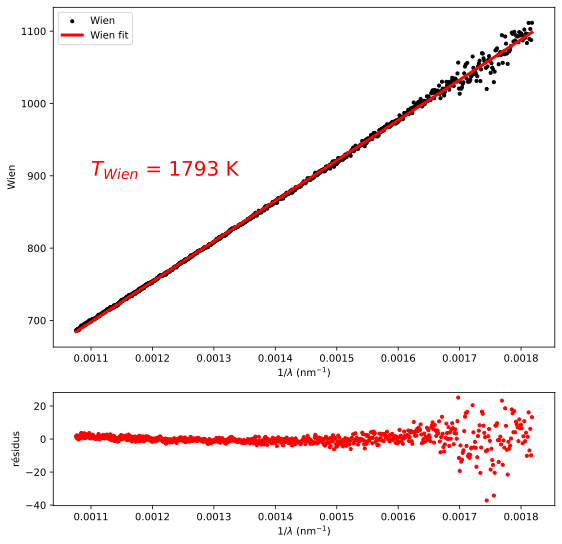

In [49]:
# La fonction retourne les coefficient du polynome, par degres décroissants:
# le dernier paramètre est l'ordre du polynome : ici 1# tel que a*x+ b:
a, b = np.polyfit(1/x, y_wien, 1)

# on réalise la figure:
fig, axs = plt.subplots(2, figsize=(9, 9), height_ratios=(3,1))

axs[0].scatter(1/x, 
               y_wien, 
               color='k', # k = black
               s=10,      # taille des points
               label='Wien') 

# on trace le fit :
axs[0].plot(1/x, 
            a/x + b,
            linewidth=3,   # épaisseur du trait
            color='r', # r = red
            label='Wien fit')

# on calcule les résidus :
res = y_wien - (a/x + b)

# on trace les résidus dans le second paneau :
axs[1].scatter(1/x, 
               res,
               color='r',
               s = 10)

# rappelons la syntaxe qui change légèrement ici pour les objets axs, pour lesquels on utilise set_xlabel...
axs[0].set_xlabel("1/$\lambda$ (nm$^{-1}$)")
axs[0].set_ylabel("Wien")

axs[1].set_xlabel("1/$\lambda$ (nm$^{-1}$)")
axs[1].set_ylabel("résidus")

axs[0].legend()


# on calcule la température et epsilon: 

temp_wien = 1e9/a  # 1e9 car nous avons fitté la loi avec lambda en nm
epsilon_wien = np.exp(- h*c*b/k)

print('Résultats du fit dans l approximation de Wien :')
print('T        =  ', round(temp_wien), 'K')
print('epsilon  =  ', round(epsilon_wien, 2))

# on peut afficher ce résultat directement sur le graphique : 

axs[0].text(0.0011,     # position x du texte dans les coordonnées des données
            900,        # position y
            '$T_{Wien}$ = ' + str(round(temp_wien)) + ' K', # chaine de caractère à afficher 
            size=20,     # taille
            color='red') # couleur

Ces valeurs sont en bon accord avec celles obtenues lors du fit de la loi de Planck : $T = 1820~K$ et $\varepsilon = 0.255$. 

### Analyse par pyrométrie deux couleurs "glissante"

En utilisant la loi linéaire de Wien ci-dessus, seuls deux points suffisent à déterminer une valeur de température. Cela permet d'étudier les éventuelles déviations à l'émission thermique d'un corps "gris" parfait (emissité indépendante de $\lambda$) en fonction de la longueur d'onde.  Cela permettra également de donner une estimation de l'incertitude sur la mesure de température. 

Pour cela, on calcule une température "deux couleurs" pour chaque couple de points du spectre : 

$$
\Large
T(\lambda_1) = \frac{1/\lambda_1 - 1/\lambda_2}{Wien(\lambda_1) - Wien(\lambda_2)}
$$

Pour des données fidèles à un corps gris, aucune dépendance particulière de $T(\lambda)$ en fonction de $\lambda$ n'est attendue mis à part du bruit.

Numériquement, nous avons un ensemble discret de longueurs d'onde {$\lambda_i$}. Nous allons calculer pour chaque points du spectre $\lambda_i$ une température pour deux longueurs d'onde séparées par $\delta$ pixels ($\delta$ est un paramètre que l'on pourra faire varier) :

$$
\Large
T(\lambda_i) = \frac{1/\lambda_i - 1/\lambda_{i+\delta}}{Wien(1/\lambda_i) - Wien(1/\lambda_{i+\delta})}
$$

Pour simplicité, on commence par s'assurer que $1/\lambda_i > 1/\lambda_{i+\delta}$. Ici nos données sont rangées par longueurs d'ondes décroissantes, nous souhaitons les ranger par valeurs croissantes. Il suffit pour cela d'inverser l'ordre des élements de `x_use` et de `y_wien` avec la fonction `np.flip` :


In [50]:
# on définit x2 et y2 :
x2 = np.flip(x)
y2 = np.flip(y_wien)

Notons que si les élements du tableau étaient totalement désordonnés, on pourrait utiliser les fonction [np.sort](https://numpy.org/doc/stable/reference/generated/numpy.sort.html) ou [np.argsort](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html). 

On calcule maintenant $T(\lambda_i)$ :

In [51]:
# Commençons par fixer une valeur de delta :
delta = 50

# numérateur : 
n = np.array([1/x2[i] - 1/x2[i + delta] for i in range(len(x2)-delta)])

# dénominateur:
d = np.array([y2[i] - y2[i + delta] for i in range(len(x2)-delta) ])

Nous avons ici utilisé une syntaxe spécifique, la [compréhension de liste](https://www.docstring.fr/glossaire/comprehension-de-liste/), qui permet en substance de réaliser une boucle `for` en une seule ligne :
```
list2 = [operation(x) for x in list1]
```
Dans cet exemple générique, on obtient un tableau `list2` où l'on a appliqué `operation` a chaque élement de `list1`. `x` est une variable temporaire qui prendra successivement les valeurs de chaque élements de `list1`. 

Pour le calcul du numérateur `n` ci dessus, 
```
n = [1/x2[i] - 1/x2[i + delta] for i in range(len(x2)-delta)]
```
ici `i` doit courir sur tous les indices du tableau `x2` jusqu'à ce que `i+delta` atteigne la fin du tableau, car $T(\lambda)$ est défini sur $[\lambda_{min}, \lambda_{max-delta}]$. 
`i` appartient donc à `range(len(x2)-delta)` où `len(x)` renvoie la longueur (le nombre d'élements) de `x`, et `range(nombre)` renvoie `[0, 1, 2, 3, ..., nombre-1]`. Ainsi, `i` prendra successivement les valeurs de `range(len(x2)-delta) = [0, 1, 2, ..., (longueur de x2) - delta - 1]`.

Notons que nous avons ajouté `np.array([...])` afin de définir des tableau `numpy`,  qui supportent les opérations arithmétiques éléments par élements contrairement aux listes de base `[...]` de python.

On calcule maintenant T($\lambda$), on calcule sa moyenne et on trace :

(0.0, 5000.0)

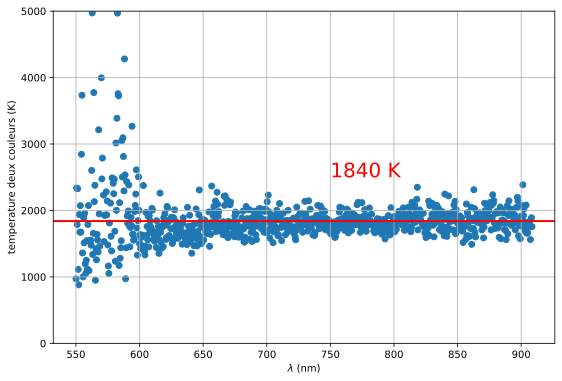

In [52]:
# la division est effectuée élements par élements :
# 1e9 car lambda était en nm
T_2couleurs = 1e9 * n/d 

# moyenne :
T_2couleurs_mean = np.mean(T_2couleurs)

# on créé une figure simple
plt.figure(figsize=(9,6))

# on peut ajouter une grille:
plt.grid()

plt.xlabel('$\\lambda$ (nm)')
plt.ylabel('temperature deux couleurs (K)')

# on trace:
# on ne garde que les élements de x2 pour lesquels T_2couleurs est défini, cf. explication ci dessous :
plt.scatter(x2[:len(x2)-delta], T_2couleurs)

# on ajoute une ligne horizontale pour la moyenne :
plt.axhline(T_2couleurs_mean, color='r', linewidth=2)

# et la valeur sur le graphe: 
plt.text(750, 2500, str(round(T_2couleurs_mean)) + ' K', 
         color='r', size=20)

# on fixe les limites du graphique en y car certaines valeurs sont aberrantes :
plt.ylim([0, 5000])


Notons que pour tracer cette fonction, il faut s'assurer d'avoir le même nombre d'élements pour `x2` et pour `T_2couleurs`. Nous avons utilisé le [slicing](https://anislerouge.com/tutorial-python-slicing/) :
```
x2[:len(x2)-delta]
```
qui renvoie tous les élements de `x2` jusqu'au "dernier élement moins delta élements", le dernier pour lequel `T_2couleurs` est défini.

Les valeurs de `T_2couleurs` ont une moyenne de $\sim 1840$ K, avec un bruit relativement important. Pour affiner notre analyse on peut regarder l'effet du paramètre `delta`, qui était ici fixé à 50 pixels.  On définit une fonction `T2couleurs` que l'on pourra réutiliser, et on regarde l'effet du paramètre `delta` sur l'écart-type (fonction `np.std`) des températures deux-couleurs : 

(0.0, 3000.0)

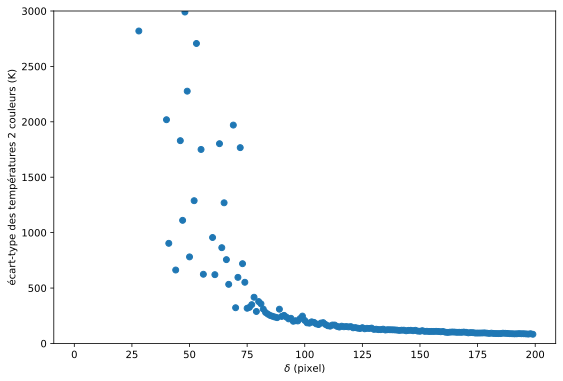

In [53]:
# on définit une fonction pour le calcul de la température deux couleurs:

def T2couleurs(lamb, wien, delta):
    # numérateur:
    n = np.array([1/lamb[i] - 1/lamb[i + delta] for i in range(len(lamb)-delta)])
    # dénominateur:
    d = np.array([wien[i] - wien[i + delta] for i in range(len(wien)-delta) ])
    
    return 1e9 * n/d


# on définit une série de valeurs de delta de 1 à 199:
deltas = np.arange(1, 200)

# Pour chaque valeur de delta on calcule l'écart-type des températures deux-couleurs via une compréhension de liste:
stds = np.array( [np.std(T2couleurs(x2, y2, d)) for d in deltas] )

# on trace les écarts-type en fonction de delta:
plt.figure(figsize=(9,6))
plt.xlabel('$\\delta$ (pixel)')
plt.ylabel('écart-type des températures 2 couleurs (K)')
plt.scatter(deltas, stds)

# on fixe les limites du graphe en y car certaines valeurs sont aberrantes, surtout aux petits delta où le bruit domine. NB: Sans préciser de limites, la figure s'adapte (autoscale) pour que tout les points soient contenus dans la figure.
plt.ylim([0, 3000])

On distingue deux régimes : à faible $\delta$ le bruit domine et les variations de température deux-couleurs sont importantes et n'apportent pas d'information utile. Aux plus grands delta, l'écart-type se stabilise et on observe une décroissance qui traduit un effet de moyennage. 

Un bon choix pour $\delta$ est un choix intermédiaire, lorsque l'écart-type commence à se stabiliser. On choisit ici $\delta = 90$. On trace l'évolution de la température deux-couleurs en fonction de la longueur d'onde avec cette valeur de `delta`, et on trace un [histogramme](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.hist.html) des températures dans une figure à deux panneaux :

Text(2250, 100, '$\\pm$ 244 K')

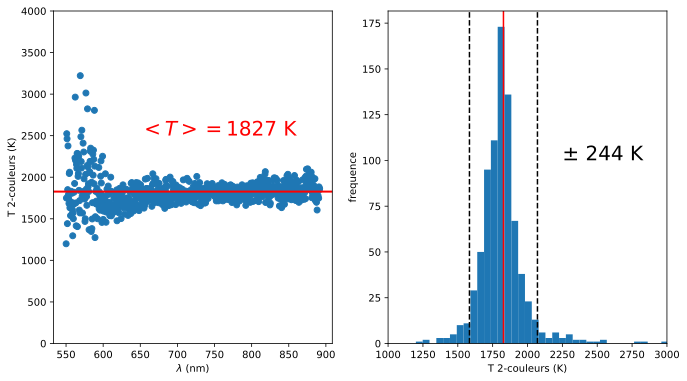

In [54]:
good_delta = 90
T2c = T2couleurs(x2, y2, good_delta)

# calcul de la moyenne et de l'écart-type:
T2c_mean = np.mean(T2c)
T2c_std = np.std(T2c)

# on définit une grille de panneau de hauteur 1, largeur 2:
fig, axs = plt.subplots(1, 2, figsize=(11, 6)) 

axs[0].set_xlabel('$\lambda$ (nm)')
axs[0].set_ylabel('T 2-couleurs (K)')

axs[1].set_xlabel('T 2-couleurs (K)')
axs[1].set_ylabel('frequence')

# on trace T2c:
axs[0].scatter(x2[:len(x2)-good_delta], T2c)

# on ajoute une ligne horizontale pour la moyenne :
axs[0].axhline(T2c_mean, color='r', linewidth=2)

# et la valeur sur le graphe: 
axs[0].text(650, 2500, '$ < T > = $' + str(round(T2c_mean)) + ' K', 
         color='r', size=20)

# on fixe les limites du graphique en y car quelques valeurs sont aberrantes :
# NB: la syntaxe change légèrement ici pour les objets axs, pour lesquels on utilise set_ylim...
axs[0].set_ylim([0, 4000])

# on trace l'histogramme dans le second panneau, avec 100 bins:
axs[1].hist(T2c, bins=100)

# on fixe les limites du graphique en x sur l'histogramme:
axs[1].set_xlim([1000, 3000])

# on ajoute des lignes verticales pour la moyenne et l'écart-type:
axs[1].axvline(T2c_mean, color='r')
axs[1].axvline(T2c_mean-T2c_std, linestyle='--', color='k')
axs[1].axvline(T2c_mean+T2c_std, linestyle='--', color='k')

# on affiche l'écart type sur le panneau de droite:
axs[1].text(2250, 100, '$\\pm$ ' + str(round(T2c_std)) + ' K',
           color='k', size=20)

On peut considérer cet écart-type comme l'erreur sur la mesure de température. On obtient ici $T = 1827 \pm 244 $ K. L'erreur est particulièrement grande car nous avons inclus les mesures en dessous de $600$ nm où le signal est faible et bruité (cf. spectre de Planck ci-dessus). 
Pour terminer cette analyse, on peut reprendre l'ensemble de nos fits dans une grande figure, en se limitant à $[600, 900]$ nm, et sauvegarder cette figure en pdf ou png.

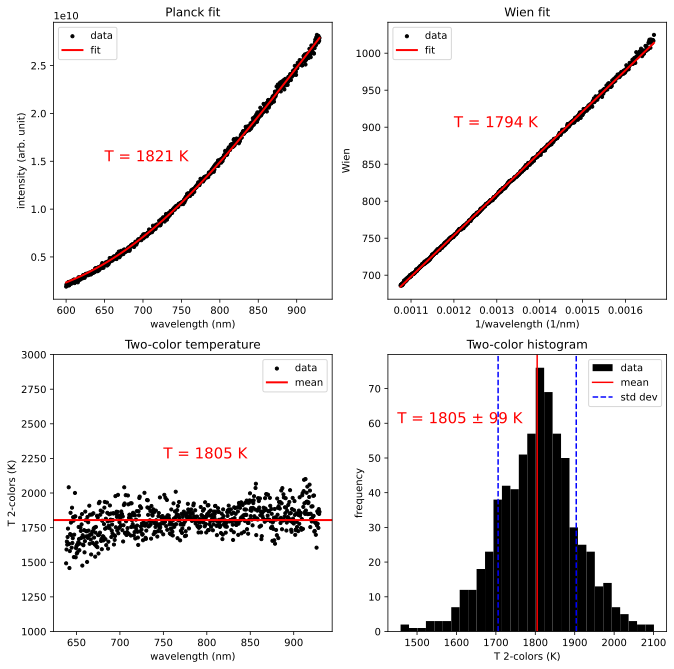

In [55]:
# selection des données, on définit x3, y3:
x3 = x_data[(x_data > 600) & (x_data < 930)]
y3 = y_data[(x_data > 600) & (x_data < 930)] 

# fit de Planck:
p_fit, cov_fit = curve_fit(planck, x3 * 1e-9, y3, p0 = p_init, bounds = p_bounds)
temp_planck = p_fit[1]

# analyse de Wien:
y3_wien = wien(1e-9 * x3, y3)
a, b = np.polyfit(1/x3, y3_wien, 1)
temp_wien = 1e9/a

# analyse deux couleurs:
T2c = T2couleurs(x3, y3_wien, good_delta)
temp_2c = np.mean(T2c)
temp_err = np.std(T2c)



# Figure à 4 panneaux:
fig, axs = plt.subplots(2, 2, figsize=(11,11))

axs[0,0].set_title('Planck fit')
axs[0,1].set_title('Wien fit')
axs[1,0].set_title('Two-color temperature')
axs[1,1].set_title('Two-color histogram')

axs[0,0].set_xlabel('wavelength (nm)')
axs[0,0].set_ylabel('intensity (arb. unit)')

axs[0,1].set_xlabel('1/wavelength (1/nm)')
axs[0,1].set_ylabel('Wien')

axs[1,0].set_xlabel('wavelength (nm)')
axs[1,0].set_ylabel('T 2-colors (K)')

axs[1,1].set_xlabel('T 2-colors (K)')
axs[1,1].set_ylabel('frequency')

# tracé des données Planck:
axs[0,0].scatter(x3, 
                 y3, 
                 color='k',
                 s=10,
                 label='data')
# fit planck:
axs[0,0].plot(x3, planck(1e-9 * x3, p_fit[0], p_fit[1]),
            linewidth=2, 
            color='r', 
            label='fit')

# affichage de la temperature:
axs[0,0].text(650, 1.5e10, 'T = ' + str(round(temp_planck)) + ' K',
             size=15, color='r')

# données Wien:
axs[0,1].scatter(1/x3, 
                 y3_wien, 
                 color='k',
                 s=10,
                 label='data')

# fit Wien:
axs[0,1].plot(1/x3, 
              a/x3 + b, 
              color='r',
              linewidth=2,
              label='fit')

# affichage de la température:
axs[0,1].text(0.0012, 900, 'T = ' + str(round(temp_wien)) + ' K',
             size=15, color='r')

# données deux couleurs:
axs[1,0].scatter(x3[:len(x3)-good_delta], T2c,
                s=10, 
                color='k', 
                label='data')

axs[1,0].set_ylim([1000, 3000])

# moyenne :
axs[1,0].axhline(temp_2c, color='r', linewidth=2, label='mean')

# affichage de la température:
axs[1,0].text(750, 2250, 'T = ' + str(round(temp_2c)) + ' K',
             size=15, color='r')

# histogramme:
axs[1,1].hist(T2c, bins=30, color='k', label='data')

# moyenne et écart-type:
axs[1,1].axvline(temp_2c, color='r', label='mean')
axs[1,1].axvline(temp_2c-temp_err, linestyle='--', color='b', label='std dev')
axs[1,1].axvline(temp_2c+temp_err, linestyle='--', color='b')

# affichage de la température:
axs[1,1].text(1450, 60, 'T = ' + str(round(temp_2c)) + ' $\pm$ ' + str(round(temp_err)) + ' K',
             size=15, color='r')

# on ajoute les légendes
axs[0,0].legend()
axs[0,1].legend()
axs[1,0].legend()
axs[1,1].legend()

# on sauvegarde la figure au format pdf, eps... (vectoriel):
fig.savefig('analyse_temperature.pdf')

# on peut sauvegarder en jpg/png...etc (non vectoriel):
fig.savefig('analyse_temperature.jpg')